<a href="https://colab.research.google.com/github/kresdev/SCA-DP/blob/master/SCA_DP_with_PyTorch_colab_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning SCA with PyTorch

In [4]:
import os
import os.path
import sys
import h5py
import torch
from tqdm.notebook import trange, tqdm

import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
#if you are running in Google Colab you can use this function for check GPU available. T4 or p100 are better than Tesla K80

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17716260478998445185, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4920332388693612038
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15564181956058085500
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14648777152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15796506931842055201
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# Generate Label for Traces

## Prepare ASCAD Code and Database

In [1]:
# first clone github from ASCAD Github
!git clone https://github.com/ANSSI-FR/ASCAD.git

Cloning into 'ASCAD'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 64 (delta 13), reused 31 (delta 10), pack-reused 30
Unpacking objects: 100% (64/64), done.


In [2]:
cd ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/

/content/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key


In [ ]:
#download ASCAD Database : ATMEGA8515 Masking Fixed Key
!wget https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip

--2020-07-31 14:14:24--  https://www.data.gouv.fr/s/resources/ascad/20180530-163000/ASCAD_data.zip
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.93
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4435199469 (4.1G) [application/zip]
Saving to: ‘ASCAD_data.zip’

ASCAD_data.zip      100%[===================>]   4.13G  19.4MB/s    in 3m 49s  

2020-07-31 14:18:15 (18.4 MB/s) - ‘ASCAD_data.zip’ saved [4435199469/4435199469]



In [ ]:
!unzip ASCAD_data.zip

Archive:  ASCAD_data.zip
   creating: ASCAD_data/
   creating: ASCAD_data/ASCAD_databases/
  inflating: ASCAD_data/ASCAD_databases/ASCAD.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync100.h5  
  inflating: ASCAD_data/ASCAD_databases/ASCAD_desync50.h5  
  inflating: ASCAD_data/ASCAD_databases/ATMega8515_raw_traces.h5  
   creating: ASCAD_data/ASCAD_trained_models/
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync0_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync100_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/cnn_best_ascad_desync50_epochs75_classes256_batchsize200.h5  
  inflating: ASCAD_data/ASCAD_trained_models/mlp_best_ascad_desync0_node200_layernb6_epochs200_classes256_batchsize100.h5  
  inflating: ASCAD_data/ASCAD_trained_models/mlp_best_ascad_desync100_node200_layernb6_epochs200_classes256_batchsize100.h5  
  inflating: ASCAD_data/ASCAD_trained_models/mlp_best

In [11]:
#download model from gdrive
!pip install gdown

In [5]:
os.makedirs("ASCAD_DATA/ASCAD_MODEL", exist_ok=True)

In [9]:
cd ASCAD_DATA/ASCAD_MODEL

/content/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/ASCAD_DATA/ASCAD_MODEL


In [13]:
!gdown https://drive.google.com/uc?id=1-BLlCkouiJwwbKlmDNRVy1UF33XKBIDZ

Downloading...
From: https://drive.google.com/uc?id=1-BLlCkouiJwwbKlmDNRVy1UF33XKBIDZ
To: /content/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/ASCAD_DATA/ASCAD_MODEL/weights.pth
267MB [00:01, 176MB/s]


In [15]:
#back to ASCAD
cd ../../../../

/content/ASCAD


In [ ]:
#if you want to change parameter when generating params, modify file example_generate_params
%run ASCAD_generate.py ATMEGA_AES_v1/ATM_AES_v1_fixed_key/example_generate_params

# Deep Learning Phase

# 1. Preparation Phase

## Import Traces and metadata Files

In [ ]:
in_file = h5py.File("ASCAD_data/ASCAD_databases/ASCAD.h5")
X_profiling = np.array(in_file['Profiling_traces/traces'], dtype=np.int8)
Y_profiling = np.array(in_file['Profiling_traces/labels'])

# data musbt be reshape to fit models (batch, channel, length)
X_profiling = X_profiling.reshape((X_profiling.shape[0], 1, X_profiling.shape[1]))

X_profiling.shape, Y_profiling.shape

C:\Users\Tes\miniconda3\envs\jcopdl\lib\site-packages\ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


((50000, 1, 700), (50000,))

### Convert data to tensor

In [ ]:
X_profiling = torch.FloatTensor(X_profiling).to(device) 
Y_profiling = torch.LongTensor(Y_profiling).to(device) 

### Set Dataset and Dataloader

In [ ]:
#set batchsize for training phase
bs_train = 200

train_set = TensorDataset(X_profiling, Y_profiling)
trainloader = DataLoader(train_set, batch_size=bs_train, shuffle=True, num_workers=0)

## Architect and Config

In [ ]:
#this model based on ASCAD on https://github.com/ANSSI-FR/ASCAD with PyTorch implementation modification
class CNNV16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            
            #block 1
            nn.Conv1d(1, 64, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            #block 2
            nn.Conv1d(64, 128, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            #block 3
            nn.Conv1d(128, 256, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
        
            #block 4
            nn.Conv1d(256, 512, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            #block 5
            nn.Conv1d(512, 512, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            nn.Flatten()
        ) 
        
        
        self.fc = nn.Sequential(
            nn.Linear(10752, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
            nn.LogSoftmax(dim=1)
        )
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# 2. Training Phase

## Set Model for Training and Test Preparation

In [ ]:
model = CNNV16().to(device)
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.00001)
# optimizer = optim.AdamW(model.parameters(), lr=0.00001)

## Training Start

In [ ]:
epochs = 75
train_cost, train_acc = [], []
for i in range(epochs):
    model.train()
    cost = correct = 0
    for feature, target in  tqdm(trainloader):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) #feedforward
        loss = criterion(output, target)
        loss.backward() #backprop

        optimizer.step() #update weight
        optimizer.zero_grad()
        

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    
    train_cost.append(cost / len(train_set))
    train_acc.append(correct/len(train_set))
        
    
    print(f"\rEpoch: {i+1}/{epochs:4} | train_cost : {train_cost[-1]:.4f} | train_acc : {train_acc[-1]:.4f}", end=" ")


Epoch: 1/  75 | train_cost : 5.5428 | train_acc : 0.0049 


Epoch: 2/  75 | train_cost : 5.5427 | train_acc : 0.0048 


Epoch: 3/  75 | train_cost : 5.5426 | train_acc : 0.0048 


Epoch: 4/  75 | train_cost : 5.5422 | train_acc : 0.0049 


Epoch: 5/  75 | train_cost : 5.5416 | train_acc : 0.0053 


Epoch: 6/  75 | train_cost : 5.5408 | train_acc : 0.0053 


Epoch: 7/  75 | train_cost : 5.5393 | train_acc : 0.0057 


Epoch: 8/  75 | train_cost : 5.5373 | train_acc : 0.0059 


Epoch: 9/  75 | train_cost : 5.5344 | train_acc : 0.0058 


Epoch: 10/  75 | train_cost : 5.5306 | train_acc : 0.0061 


Epoch: 11/  75 | train_cost : 5.5245 | train_acc : 0.0068 


Epoch: 12/  75 | train_cost : 5.5165 | train_acc : 0.0080 


Epoch: 13/  75 | train_cost : 5.5041 | train_acc : 0.0084 


Epoch: 14/  75 | train_cost : 5.4860 | train_acc : 0.0091 


Epoch: 15/  75 | train_cost : 5.4612 | train_acc : 0.0102 


Epoch: 16/  75 | train_cost : 5.4348 | train_acc : 0.0115 


Epoch: 17/  75 | train_cost : 5.4098 | train_acc : 0.0126 


Epoch: 18/  75 | train_cost : 5.3876 | train_acc : 0.0137 


Epoch: 19/  75 | train_cost : 5.3644 | train_acc : 0.0149 


Epoch: 20/  75 | train_cost : 5.3436 | train_acc : 0.0158 


Epoch: 21/  75 | train_cost : 5.3203 | train_acc : 0.0170 


Epoch: 22/  75 | train_cost : 5.2985 | train_acc : 0.0183 


Epoch: 23/  75 | train_cost : 5.2764 | train_acc : 0.0193 


Epoch: 24/  75 | train_cost : 5.2513 | train_acc : 0.0216 


Epoch: 25/  75 | train_cost : 5.2260 | train_acc : 0.0233 


Epoch: 26/  75 | train_cost : 5.1983 | train_acc : 0.0253 


Epoch: 27/  75 | train_cost : 5.1674 | train_acc : 0.0271 


Epoch: 28/  75 | train_cost : 5.1372 | train_acc : 0.0297 


Epoch: 29/  75 | train_cost : 5.1053 | train_acc : 0.0318 


Epoch: 30/  75 | train_cost : 5.0682 | train_acc : 0.0355 


Epoch: 31/  75 | train_cost : 5.0309 | train_acc : 0.0370 


Epoch: 32/  75 | train_cost : 4.9939 | train_acc : 0.0402 


Epoch: 33/  75 | train_cost : 4.9483 | train_acc : 0.0442 


Epoch: 34/  75 | train_cost : 4.9078 | train_acc : 0.0472 


Epoch: 35/  75 | train_cost : 4.8597 | train_acc : 0.0525 


Epoch: 36/  75 | train_cost : 4.8087 | train_acc : 0.0563 


Epoch: 37/  75 | train_cost : 4.7616 | train_acc : 0.0609 


Epoch: 38/  75 | train_cost : 4.7089 | train_acc : 0.0668 


Epoch: 39/  75 | train_cost : 4.6508 | train_acc : 0.0720 


Epoch: 40/  75 | train_cost : 4.5931 | train_acc : 0.0777 


Epoch: 41/  75 | train_cost : 4.5304 | train_acc : 0.0833 


Epoch: 42/  75 | train_cost : 4.4711 | train_acc : 0.0902 


Epoch: 43/  75 | train_cost : 4.3987 | train_acc : 0.0982 


Epoch: 44/  75 | train_cost : 4.3437 | train_acc : 0.1023 


Epoch: 45/  75 | train_cost : 4.2691 | train_acc : 0.1138 


Epoch: 46/  75 | train_cost : 4.1967 | train_acc : 0.1239 


Epoch: 47/  75 | train_cost : 4.1275 | train_acc : 0.1305 


Epoch: 48/  75 | train_cost : 4.0517 | train_acc : 0.1410 


Epoch: 49/  75 | train_cost : 3.9706 | train_acc : 0.1521 


Epoch: 50/  75 | train_cost : 3.9037 | train_acc : 0.1594 


Epoch: 51/  75 | train_cost : 3.8139 | train_acc : 0.1724 


Epoch: 52/  75 | train_cost : 3.7398 | train_acc : 0.1834 


Epoch: 53/  75 | train_cost : 3.6476 | train_acc : 0.1969 


Epoch: 54/  75 | train_cost : 3.5685 | train_acc : 0.2111 


Epoch: 55/  75 | train_cost : 3.4925 | train_acc : 0.2229 


Epoch: 56/  75 | train_cost : 3.3967 | train_acc : 0.2377 


Epoch: 57/  75 | train_cost : 3.3154 | train_acc : 0.2499 


Epoch: 58/  75 | train_cost : 3.2325 | train_acc : 0.2622 


Epoch: 59/  75 | train_cost : 3.1306 | train_acc : 0.2809 


Epoch: 60/  75 | train_cost : 3.0485 | train_acc : 0.2935 


Epoch: 61/  75 | train_cost : 2.9626 | train_acc : 0.3103 


Epoch: 62/  75 | train_cost : 2.8747 | train_acc : 0.3228 


Epoch: 63/  75 | train_cost : 2.7814 | train_acc : 0.3421 


Epoch: 64/  75 | train_cost : 2.6907 | train_acc : 0.3615 


Epoch: 65/  75 | train_cost : 2.6085 | train_acc : 0.3755 


Epoch: 66/  75 | train_cost : 2.5178 | train_acc : 0.3926 


Epoch: 67/  75 | train_cost : 2.4278 | train_acc : 0.4098 


Epoch: 68/  75 | train_cost : 2.3364 | train_acc : 0.4272 


Epoch: 69/  75 | train_cost : 2.2564 | train_acc : 0.4436 


Epoch: 70/  75 | train_cost : 2.1757 | train_acc : 0.4619 


Epoch: 71/  75 | train_cost : 2.0969 | train_acc : 0.4756 


Epoch: 72/  75 | train_cost : 1.9992 | train_acc : 0.4962 


Epoch: 73/  75 | train_cost : 1.9332 | train_acc : 0.5087 


Epoch: 74/  75 | train_cost : 1.8483 | train_acc : 0.5298 


Epoch: 75/  75 | train_cost : 1.7689 | train_acc : 0.5483 

## Save Model

In [ ]:
os.makedirs("ASCAD_DATA/ASCAD_MODEL", exist_ok=True)

In [ ]:
torch.save(model.state_dict(), "ASCAD_DATA/ASCAD_MODEL/weights_3.pth")

In [ ]:
log = {
    "train_cost": train_cost,
    "train_acc": train_acc,
}
torch.save(log, "ASCAD_DATA/ASCAD_MODEL/logs_3.pth")

# Load Model Phase

In [ ]:
class CNNV16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            
            #block 1
            nn.Conv1d(1, 64, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            #block 2
            nn.Conv1d(64, 128, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            #block 3
            nn.Conv1d(128, 256, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
        
            #block 4
            nn.Conv1d(256, 512, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            #block 5
            nn.Conv1d(512, 512, 11, 1, 5),
            nn.ReLU(),
            nn.AvgPool1d(2, 2, 0),
            
            nn.Flatten()
        ) 
        
        
        self.fc = nn.Sequential(
            nn.Linear(10752, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 256),
            nn.LogSoftmax(dim=1)
        )
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [ ]:
weights = torch.load("ASCAD_DATA/ASCAD_MODEL/weights.pth", map_location="cpu")

In [ ]:
model = CNNV16().to(device)
model.load_state_dict(weights)
model = model.to(device)

# 3. Retrieve Key Phase

In [ ]:
AES_Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])

### Data Preparation

In [ ]:
#num of traces for test
num_traces_test = 5000


X_attack          = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
metadata_attack   = np.array(in_file['Attack_traces/metadata'])

#reshape traces to num traces test

X_attack          = X_attack[:num_traces_test]
plainText_attack  = metadata_attack['plaintext'][:num_traces_test]
key_attack        = metadata_attack['key'][:num_traces_test]

X_attack = X_attack.reshape((X_attack.shape[0], 1, X_attack.shape[1]))

X_attack.shape, plainText_attack.shape, key_attack.shape

((5000, 1, 700), (5000, 16), (5000, 16))

In [ ]:
#batch size for test
bs_test = 200

X_attack          = torch.FloatTensor(X_attack).to(device) 
plainText_attack  = torch.IntTensor(plainText_attack).to(device)
key_attack        = torch.IntTensor(key_attack).to(device)

test_set = TensorDataset(X_attack, plainText_attack, key_attack)
testloader = DataLoader(test_set, batch_size=bs_test, shuffle=False)

In [ ]:
# get key byte 3 from metadata
byte_attacked = 3

real_key = key_attack[0][byte_attacked-1]
real_key = real_key.item()
real_key

224

## Test Start

In [ ]:
P_k = np.zeros(256)
traces_num = []
rank_traces = []
num_start = 0

for feature, plaintext, key in  tqdm(testloader):
    feature, plaintext, key = feature.to(device), plaintext.to(device), key.to(device)
    
    with torch.no_grad():
        model.eval()
        predictions = model(feature)

    for j in range(feature.shape[0]):

        # Test each key
        for k in range(256):
        
            pt = plaintext[j][byte_attacked-1].item()

            #find probability for specific first Sbox
            proba = predictions[j][AES_Sbox[pt ^ k]]

            # Add it to running total
            P_k[k] += proba


        traces_num.append(j+num_start)
        rank_traces.append(255-np.where(P_k.argsort() == real_key)[0])

    num_start = num_start+feature.shape[0]

## Plot Data

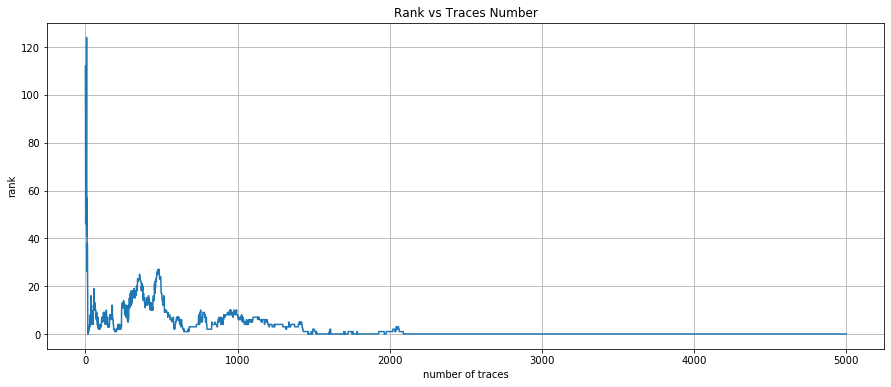

This is the key Guess:  0xe0 rank:  [0]
Attack succeed


In [ ]:
plt.figure(figsize=(15, 6))
plt.title('Rank vs Traces Number')
plt.xlabel('number of traces')
plt.ylabel('rank')
plt.grid(True)
plt.plot(traces_num, rank_traces)
plt.show()

guess = P_k.argsort()[-1]
print("This is the key Guess: ", hex(guess), "rank: ", rank_traces[-1])
if(rank_traces[-1]==0):
    print("Attack succeed")
